In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
from math import ceil
import os
import random
import matplotlib.pylab as plt
import plotly.express as px
from zipfile import ZipFile
from PIL import Image, ImageEnhance; Image.MAX_IMAGE_PIXELS = 5_000_000_000

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense,MaxPooling2D, MaxPool2D, Conv2D,Flatten,Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from kaggle_datasets import KaggleDatasets

In [3]:
import random


list_of_categories = os.listdir('/kaggle/input/imagenetmini-1000/imagenet-mini/train/')

number_of_categories = len(list_of_categories)

# sample_category = list_of_categories[random.choice(range(number_of_categories))]
sample_category = "n02093647" # Dogs

print(sample_category)

sample_photos_list = os.listdir('/kaggle/input/imagenetmini-1000/imagenet-mini/train/{}'.format(sample_category))


n02093647


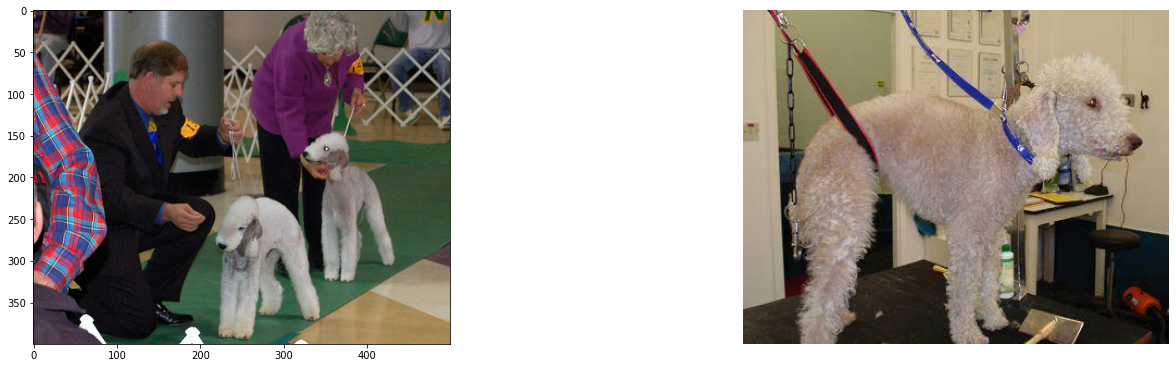

In [4]:
# Plotting samples

plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
sample_photo_filename_1 = random.choice(sample_photos_list)
image_1 = load_img('/kaggle/input/imagenetmini-1000/imagenet-mini/train/{}/{}'.format(sample_category, sample_photo_filename_1))
plt.imshow(image_1)

plt.subplot(2, 2, 2)
sample_photo_filename_2 = random.choice(sample_photos_list)
image_2 = load_img('/kaggle/input/imagenetmini-1000/imagenet-mini/train/{}/{}'.format(sample_category, sample_photo_filename_2))
plt.imshow(image_2)

plt.axis('off')

plt.tight_layout()

Width: 334 pixels, Height: 411 pixels
Max pixel value: 255, Min pixel value: 0
Mean pixel value: 127.3955519617699, Standard Deviation: 80.1506666446969


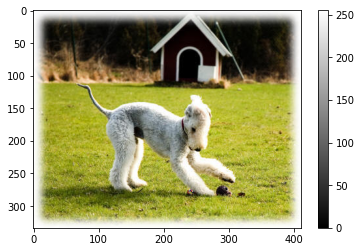

In [5]:
# Pixel analysis

sample_photo_filename_3 = random.choice(sample_photos_list)
image_3 = plt.imread('/kaggle/input/imagenetmini-1000/imagenet-mini/train/{}/{}'.format(sample_category, sample_photo_filename_3))

plt.imshow(image_3, cmap='gray')
plt.colorbar()
# plt.title('Dog Image')

print("Width: {} pixels, Height: {} pixels".format(image_3.shape[0], image_3.shape[1]))
print("Max pixel value: {}, Min pixel value: {}".format(image_3.max(), image_3.min()))
print("Mean pixel value: {}, Standard Deviation: {}".format(image_3.mean(), image_3.std()))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

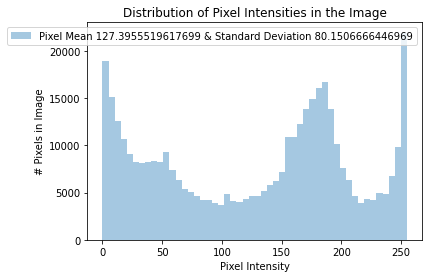

In [6]:
# Pixel distribution

import seaborn as sns

sns.distplot(image_3.ravel(),
             label="Pixel Mean {} & Standard Deviation {}".format(np.mean(image_3),np.std(image_3)), 
             kde=False)
plt.legend(loc='upper right')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [7]:
# Credit: https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
dog_images_matrix = img2np('/kaggle/input/imagenetmini-1000/imagenet-mini/train/{}/'.format(sample_category), sample_photos_list)

In [8]:
# Credit: https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2
def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()

Number of PC:  10


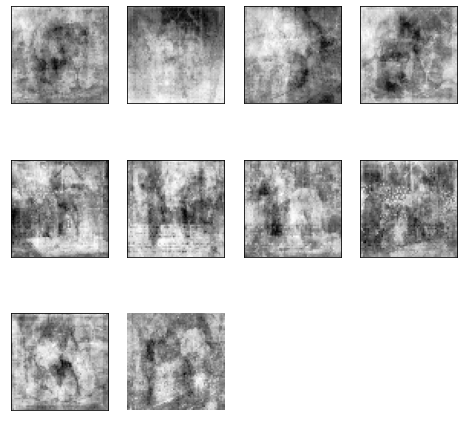

In [9]:
plot_pca(eigenimages(dog_images_matrix, 'Dogs'))

In [10]:
# From https://www.kaggle.com/code/dschettler8845/guie-a-better-tensorflow-example-baseline-model

def build_guie_model(wt_path, tf_keras_model_fn):
    _inputs = tf.keras.layers.Input(shape=(None,None,3), batch_size=1, dtype=tf.uint8, name="inputs")
    _bb = tf_keras_model_fn(include_top=False, weights=wt_path)
    x = tf.keras.layers.GlobalAveragePooling2D()(_bb(_inputs))
    x = tf.keras.layers.Reshape((-1,1))(x)
    x = tf.keras.layers.AveragePooling1D(22)(x)
    _output_1 = tf.keras.layers.Reshape((-1,), name="embedding")(x)
    _output_2 = tf.keras.layers.Lambda(lambda x: tf.nn.l2_normalize(x), name="embedding_norm")(_output_1)    
    return tf.keras.Model(inputs=_inputs, outputs=[_output_1, _output_2])

IMAGENET_WEIGHTS = "imagenet"
TF_KERAS_MODEL_FN = tf.keras.applications.EfficientNetB2

guie_model = build_guie_model(IMAGENET_WEIGHTS, TF_KERAS_MODEL_FN)
guie_model.summary()

os.makedirs("/kaggle/models", exist_ok=True)
guie_model.save("/kaggle/models")

2022-07-26 20:16:54.619366: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


31801344/31790344 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(1, None, None, 3)]      0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, None, None, 1408)  7768569   
_________________________________________________________________
global_average_pooling2d (Gl (1, 1408)                 0         
_________________________________________________________________
reshape (Reshape)            (1, 1408, 1)              0         
_________________________________________________________________
average_pooling1d (AveragePo (1, 64, 1)                0         
_________________________________________________________________
embedding (Reshape)          (1, 64)                   0         
______________________________________________________________

2022-07-26 20:17:20.885194: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [11]:
from zipfile import ZipFile

with ZipFile('/kaggle/submission.zip','w') as zip:           
  zip.write('/kaggle/models/saved_model.pb', arcname='saved_model.pb') 
  zip.write('/kaggle/models/variables/variables.data-00000-of-00001', arcname='variables/variables.data-00000-of-00001') 
  zip.write('/kaggle/models/variables/variables.index', arcname='variables/variables.index') 

In [12]:
saved_model_path = "/kaggle/models"
image_path       =  "/kaggle/input/imagenetmini-1000/imagenet-mini/val/n03976657/ILSVRC2012_val_00043517.JPEG"

# Model loading.
model = tf.saved_model.load(saved_model_path)
embedding_fn = model.signatures["serving_default"]

# Load image and extract its embedding.
image_tensor = tf.convert_to_tensor(np.array(Image.open(image_path).convert("RGB")))
expanded_tensor = tf.expand_dims(image_tensor, axis=0)
embedding = embedding_fn(expanded_tensor)["embedding_norm"]

print(embedding)

2022-07-26 20:18:07.810312: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


tf.Tensor(
[[ 0.00424104 -0.00309125  0.06971809  0.11709455  0.01127278 -0.20903641
   0.19582137  0.2841709   0.0031136  -0.12753989  0.14954698  0.05678393
  -0.09038787  0.19891706 -0.0234745   0.39934605  0.069521   -0.08409726
   0.07238551 -0.09384564  0.11634111  0.03435458 -0.10257519  0.00247126
  -0.0017606  -0.06634741  0.06826057  0.00673233 -0.15819974 -0.09148769
  -0.08603235 -0.03015553  0.01305693 -0.055285    0.11233662 -0.03781436
   0.10959917  0.00139897 -0.06495626 -0.08267456  0.20634188 -0.02311999
  -0.05051138 -0.10714962 -0.08491712  0.13298754 -0.0986499  -0.02896317
  -0.03839102 -0.04062668 -0.03942045  0.02705807  0.29103655 -0.07825266
   0.26930922 -0.02741115 -0.01091008 -0.13835526  0.34301147  0.0969143
   0.0184736  -0.01615847  0.01060847 -0.13167116]], shape=(1, 64), dtype=float32)
